In [1]:
bigpage = True
from IPython.core.display import display, HTML
if bigpage:
    display(HTML("<style>.container { width:90% !important; }</style>"))
else:
    display(HTML("<style>.container { width:1140px !important; }</style>"))

In [2]:
from accuracy_test import x, y, file_prefix
from numpy import (log10, sqrt, maximum, minimum, median, pi, arccos, load, argsort,
                   concatenate, array, empty, linalg, linspace, unravel_index)
%matplotlib notebook
# %matplotlib qt
from matplotlib import pyplot as plt
from FFT_simulator import getFTpoints, planes2basis
from cycler import cycler
import pyxem as pxm
# from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from subpixelrefinement_generator import SubpixelrefinementGenerator
from hyperspy.api import preferences; preferences.General.show_progressbar = False

clist, slist = list('bgrmkcy'), ['-', '--', ':', '-.']
plt.rc('axes', prop_cycle=(cycler('color', clist*len(slist)) + cycler('linestyle', slist*len(clist))))
if bigpage:
    plt.rcParams['figure.figsize'] = [14.9, 6]
else:
    plt.rcParams['figure.figsize'] = [9.5, 6]
def figure(name, *args, **kwargs):
    plt.close(name); f = plt.figure(name, *args, **kwargs);return f

n, alpha, rotate = 450, 0, True
filename = file_prefix + '_' + str(n) + '_' + str(max(0,alpha)).replace('.','p')
assert n == x[0].size

def plot_FT(thing, *args, origin='lower', **kwargs):
    if thing.ndim == 2:
        plt.imshow(thing, *args, aspect='equal', extent=[y[0][0], y[0][-1], y[1][0], y[1][-1]], origin=origin, **kwargs)
    else:
        plt.plot(y[0], thing, *args, **kwargs)

sqrt = lambda x: x ** .5
def norm(*x):
    if len(x) == 1:
        x = x[0]
    return sqrt(abs(x[0])**2+abs(x[1])**2)

def padSpots(s):
    if s.shape[-1] == 3:
        return s
    else:
        S = empty(s.shape[:-1]+(3,))
        S[...,:2], S[...,2] = s, 0
        return S

In [3]:
gt, DP, strain, inv_strain = {},{},{},{}
stackList = [1,3,10]

for rot in (True,False):
    tmp = load(filename+'_0' + ('_flipped' if rot else '') + '.npy', allow_pickle=True)[()]
    for k in ('precessed','flat'):
        gt[(rot,k)] = tmp[k]/tmp[k].max()
    if alpha<0:
        gt[(rot,'precessed')] = gt[(rot,'flat')]
    
    precessed, flat, strain[rot] = [], [], []
    for i in range(3):
        tmp = load(filename+'_' + str(i+1) + ('_flipped' if rot else '') + '.npy', allow_pickle=True)[()]
        if alpha>=0:
            precessed.append(tmp['precessed'])
        else:
            precessed.append(tmp['flat'])
        flat.append(tmp['flat'])
        strain[rot].append(tmp['strain'])

    precessed, flat = concatenate(precessed, axis=0), concatenate(flat, axis=0)
    precessed /= precessed.max(axis=(-1,-2), keepdims=True)
    flat /= flat.max(axis=(-1,-2), keepdims=True)
    buf = empty(precessed.shape[:3], dtype=object).reshape(len(strain[rot]),-1)
    for i in range(len(strain[rot])):
            buf[i,:] = strain[rot][i]
    strain[rot] = buf.reshape(precessed.shape[:3])
    DP[(rot,'precessed')] = precessed
    DP[(rot,'flat')] = flat
    stackList = tmp['stackList']
    del tmp # free memory for next load
    

    inv_strain[rot] = empty(strain[rot].shape, dtype='object')
    for i in range(strain[rot].shape[0]):
        for j in range(strain[rot].shape[1]):
            for k in range(strain[rot].shape[2]):
                inv_strain[rot][i,j,k] = linalg.inv(strain[rot][i,j,k])

spots= {True:array([[1.16,1.65], [1.16,-1.65], [-1.16,1.65], [-1.16,-1.65], [0,3.28], [0,-3.28]])[:,::-1],
       False:concatenate((2.32*array([[1,1], [1,-1], [-1,1],[-1,-1]]), 4.66*array([[0,1], [0,-1], [-1,0],[1,0]])), axis=0)[:,::-1]}
# [:,::-1] switches from (y,x) format to (x,y)

<IPython.core.display.Javascript object>


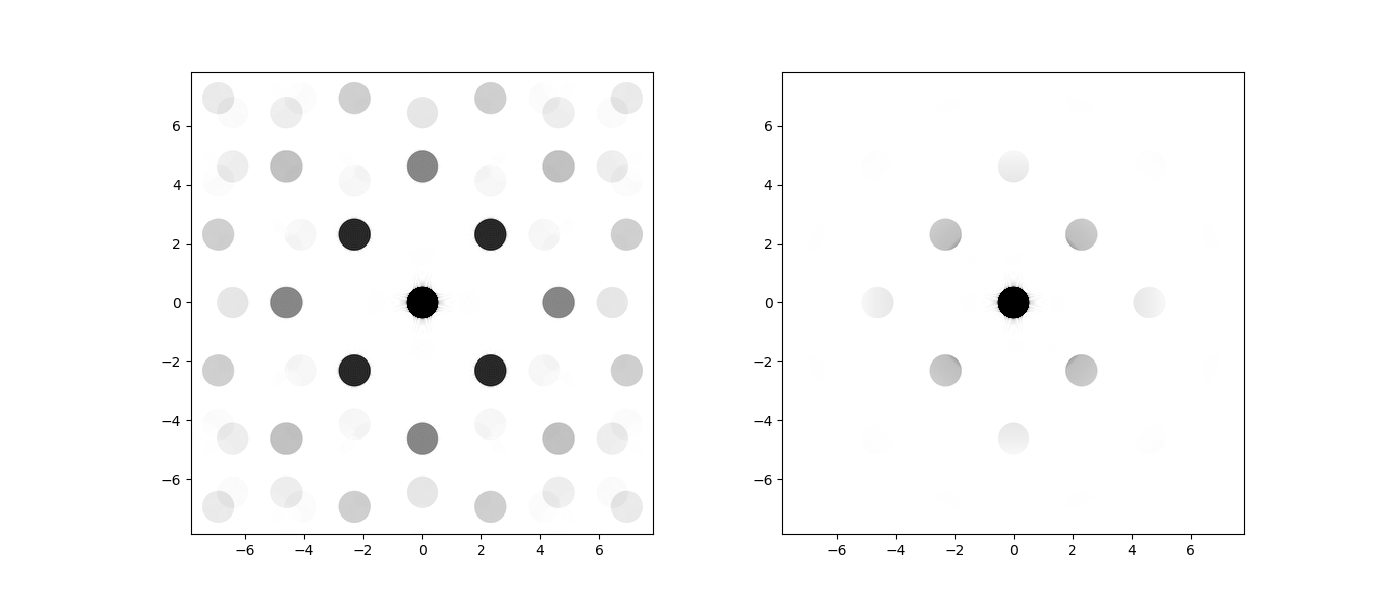

In [4]:
figure('tmp', figsize=(14,6))
thresh, scale =.1, lambda x: 1-maximum(1e-5,minimum(x,thresh))**.5
plt.subplot(121); plot_FT(scale(gt[(False,'flat')]))
plt.subplot(122); plot_FT(scale(gt[(False,'precessed')]))
if alpha==0 and rotate==False:
    plt.savefig('kinematic_demos_noprecession.png', dpi=300)
elif alpha==2 and rotate==False:
    plt.savefig('kinematic_demos.png', dpi=300)

<IPython.core.display.Javascript object>


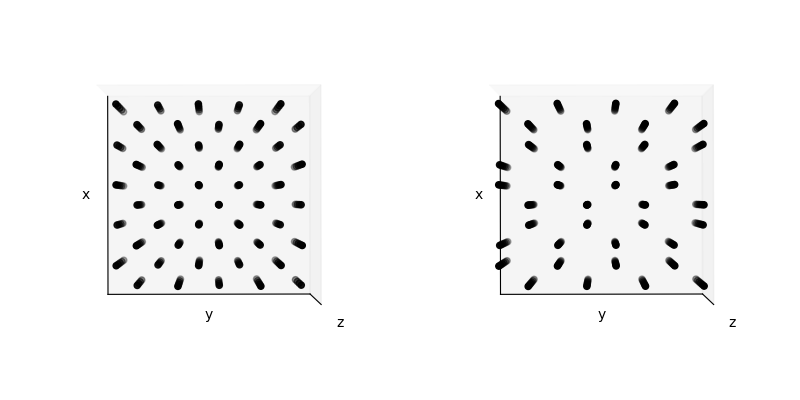

In [41]:
from mpl_toolkits.mplot3d import Axes3D
from accuracy_test import crystal, spacing, getSiBlock
crystal1 = crystal(spacing*getSiBlock(width=5, rotate=False), 14)
crystal1 = crystal1.translate(-crystal1.box[:, 1] / 2)
crystal2 = crystal(spacing*getSiBlock(width=5, rotate=True), 14)
crystal2 = crystal2.translate(-crystal2.box[:, 1] / 2)

d0 = [d for d in crystal1.loc if abs(d[0])<7 and abs(d[1])<7 and abs(d[2])<12]
d1 = [d for d in crystal2.loc if abs(d[0])<7 and abs(d[1])<7 and abs(d[2])<12]
d0,d1 = array(d0).T, array(d1).T
ticks, lims = [], (-7, 7)
fig = figure('crystal', figsize=(8,4))
ax = fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')
ax[0].scatter(*d0, color='k');
ax[1].scatter(*d1, color='k');
for a in ax:
    a.view_init(89.9, -.1);
    a.set_xticks(ticks); a.set_yticks(ticks); a.set_zticks(ticks)
    a.set_xlim(lims); a.set_ylim(lims)
    a.set_xlabel('x'); a.set_ylabel('y'); a.set_zlabel('z')
    a.xaxis.labelpad=-5; a.yaxis.labelpad=-5; a.zaxis.labelpad=-5
plt.tight_layout()
plt.savefig('phantoms.png', dpi=300)

<IPython.core.display.Javascript object>


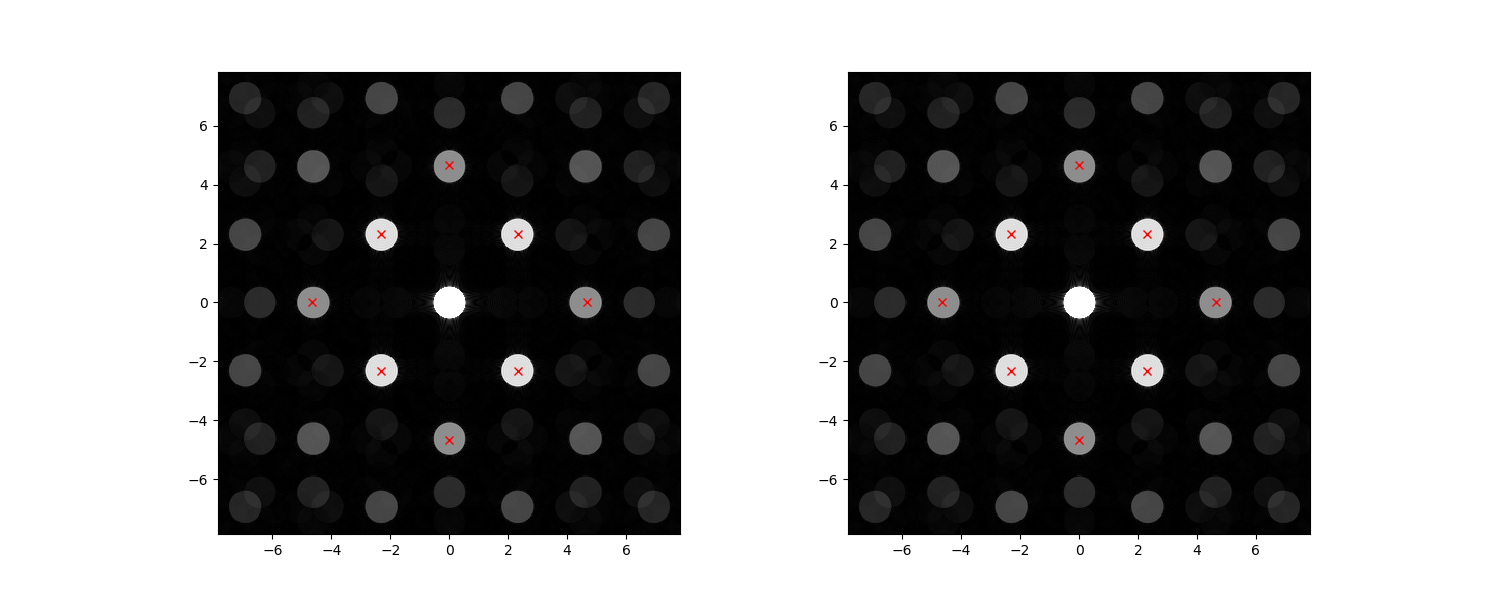

In [5]:
thresh, scale =.1, lambda x: maximum(1e-10,minimum(x,thresh)**.4)
figure('GT')
plt.subplot(121); plot_FT(scale(gt[(rotate,'flat')]))
plt.plot(spots[rotate][:,0], spots[rotate][:,1], 'rx')
plt.subplot(122); plot_FT(scale(gt[(rotate,'precessed')]))
plt.plot(spots[rotate][:,0], spots[rotate][:,1], 'rx')

In [6]:
spot_rad = 0.57, .85 # radius of spot, distance from center of one spot to edge of the next
spot_rad = {True:spot_rad, False:spot_rad}

def predict(spots, strain):
    SPOTS = padSpots(spots[:,:2]) # [:,(x,y,z)] format
    SPOTS = SPOTS[:,(1,0,2)] # [:,ax=(0,1,2)] format
    scatter = empty(strain.shape+(spots.shape[0],), dtype=object)
    out = empty(strain.shape+(spots.shape[0],2))
    for i in range(strain.shape[0]):
        for j in range(strain.shape[1]):
            for k in range(strain.shape[2]):
                for l in range(spots.shape[0]):
                    scatter[i,j,k,l] = array([linalg.solve(s.T, SPOTS[l])[1::-1] for s in strain[i,j,k]])
                    out[i,j,k,l] = sum(scatter[i,j,k,l])/strain[i,j,k].shape[0]
    return scatter, out

def getCOMs(arr, points, rad, method='com', reference=None):
    # Assume points in [:,(x,y)] format
    # returns points in [:,(x,y)] format
    insz = arr.shape
    
    signal = pxm.ElectronDiffraction2D(arr.reshape((-1,)+insz[-3:]))
    signal.set_diffraction_calibration(y[0][1]-y[0][0])

    midsz = signal.data.shape
    if points.ndim == 2:
        spg = SubpixelrefinementGenerator(signal, points)
    else:
        tmp = pxm.DiffractionVectors(points.reshape(midsz[:2]+(-1,2)))
        tmp.axes_manager.set_signal_dimension(2)
        spg = SubpixelrefinementGenerator(signal, tmp)
    
    if method == 'com':
        peaks = spg.center_of_mass_method(2*int(rad[1]/(y[1][1]-y[1][0])))
    elif method == 'lgm':
        peaks = spg.local_gaussian_method(2*int(rad[1]/(y[1][1]-y[1][0])))
    elif method == 'xc':
        peaks = spg.conventional_xc(2*int(rad[1]/(y[1][1]-y[1][0])), 
                                    int(rad[0]/(y[1][1]-y[1][0])),
                                    50)
    elif method == 'rxc':
        peaks = spg.reference_xc(reference,
                                 2*int(rad[1]/(y[1][1]-y[1][0])), 
                                 50)
    else:
        raise NotImplementedError("Your method, %s, is not currently supported.\nPlease choose from 'com', 'lgm', and 'xc'"%method)
        
    return peaks.data.reshape(*insz[:-2],-1,2)

names = [['Plain CoM','com'], ['Sqrt CoM','sqrt com'], ['Plain XC', 'xc'], 
         ['Sqrt XC', 'sqrt xc'], ['Plain RXC', 'rxc'], ['Sqrt RXC', 'sqrt rxc']]
coms, scatter, predicted = {},{},{}
for rot in (True,False):
    for _,name in names:
        arr, ref = DP[(rot,'precessed')], gt[(rot,'precessed')]
        if 'sqrt' in name:
            arr = sqrt(arr)
            ref = sqrt(ref)

        print('\rtype %s,  '%name, end=' '*30)
        if 'rxc' in name:
            spots2 = getCOMs(ref, spots[rot], spot_rad[rot], 'xc') # use xc updated guess of spot locations
            coms[('exact '+name,rot)] = getCOMs(ref, spots2, spot_rad[rot], 'rxc', ref) # without strain
            coms[(name,rot)] = getCOMs(arr, coms[('exact '+name,rot)], spot_rad[rot], 'rxc', ref) # with strain
        else:
            coms[('exact '+name,rot)] = getCOMs(ref, spots[rot], spot_rad[rot], 'xc' if 'xc' in name else 'com') # without strain
            coms[(name,rot)] = getCOMs(arr, coms[('exact '+name,rot)], spot_rad[rot], 'xc' if 'xc' in name else 'com') # with strain
            
    print('\r' + ' '*100 + '\rCenters complete, rot=%s'%rot)

    for _,name in names:
        tmp = predict(coms[('exact '+name,rot)], strain[rot])
        scatter[(name,rot)] = tmp[0]
        predicted[(name,rot)] = tmp[1]
    print('Strained centers complete, rot=%s'%rot)
    

Centers complete, rot=True                                                                          
Strained centers complete, rot=True
Centers complete, rot=False                                                                         
Strained centers complete, rot=False


In [7]:
pixel_error = 0.0*max(abs(y[0][1]-y[0][0]), abs(y[1][1]-y[1][0])) # This error will be rounded to 0

def correctShapes(list1,list2,cut=False):
    # input shapes are one of:
    #     - (n precess,strain1,strain2,n spot,2)
    #     - (n precess,n spot,2)
    #     - (n precess,n spot,3)
    #     - (n spot,3)
    if list1.ndim < list2.ndim:
        if list1.ndim == 2:
            list1 = list1.reshape((1,)*(list2.ndim-list1.ndim) + list1.shape)
        else: 
            list1 = list1.reshape(list1.shape[:1]+(1,)*(list2.ndim-list1.ndim) + list1.shape[2:])
    elif list1.ndim > list2.ndim:
        return correctShapes(list2,list1,cut)
    if cut:
        return list1[...,:2], list2[...,:2]
    else:
        return list1, list2

def L2error(list1, list2):
    list1,list2 = correctShapes(list1,list2, cut=True)
    return maximum(0, sqrt(((list1-list2)**2).sum(-1))-pixel_error)/(1e-10+sqrt((list1**2).sum(-1)))

def angularerror(list1, list2): 
    list1,list2 = correctShapes(list1,list2, cut=True)
    thing = (list1*list2).sum(-1)
    r2 = maximum(1e-6, sqrt((list1**2).sum(-1)*(list2**2).sum(-1)))
    thing = minimum(thing/r2, 1)
    return maximum(0, arccos(thing)-pixel_error/r2**.5)/pi

def radialerror(list1, list2):
    list1,list2 = correctShapes(list1,list2, cut=True)
    r1, r2 = sqrt((list1**2).sum(-1)), sqrt((list2**2).sum(-1))
    tmp = r1-r2
    tmp[tmp>0] = maximum(0,tmp[tmp>0]-pixel_error)
    tmp[tmp<0] = minimum(0,tmp[tmp<0]+pixel_error)
    return tmp/r1

def HEADER(): print('|      Label      | Median |  Mean  |   STD  |   max  |\n'+'-'*55)
def FOOTER(): print('-'*55)
def PRINT(S,A): print('|%16.16s | % .3f | % .3f | % .3f | % .3f |'%(S, median(A), A.mean(), A.std(), abs(A).max()))
def TABLE(S,A): 
    frmt = '|%12.12s |  %.2f%% |  %.2f%% |  %.3f%% |  %.3f%% |  %+.3f%%  |   %.2f%%  |'
    n = [S]
    for i in range(3):
        B = 100*A[i]
        n.extend(((median(B)+B.mean())/2, B.std()))
    return frmt%tuple(n)

def plotHist(ax, s, S, arr, bins):
    PRINT(s, arr.reshape(-1))
    ax.hist(arr.reshape(-1), bins=bins, density=True, histtype='step', label=S)
#     ax.set_xscale('symlog', linthreshx=1e-0) # linear from 1 percent
#     ax.set_yscale('symlog', linthreshy=1) # linear at 1 density
    ax.set_ylim(0,5)
    

# errors[(name,rot)] = (metric,strain dimension,strain layers,repeat,n spot)
errors = {k:concatenate([f(predicted[k],coms[k])[None] for f in (L2error, angularerror,radialerror)], axis=0)
         for k in predicted}

<IPython.core.display.Javascript object>


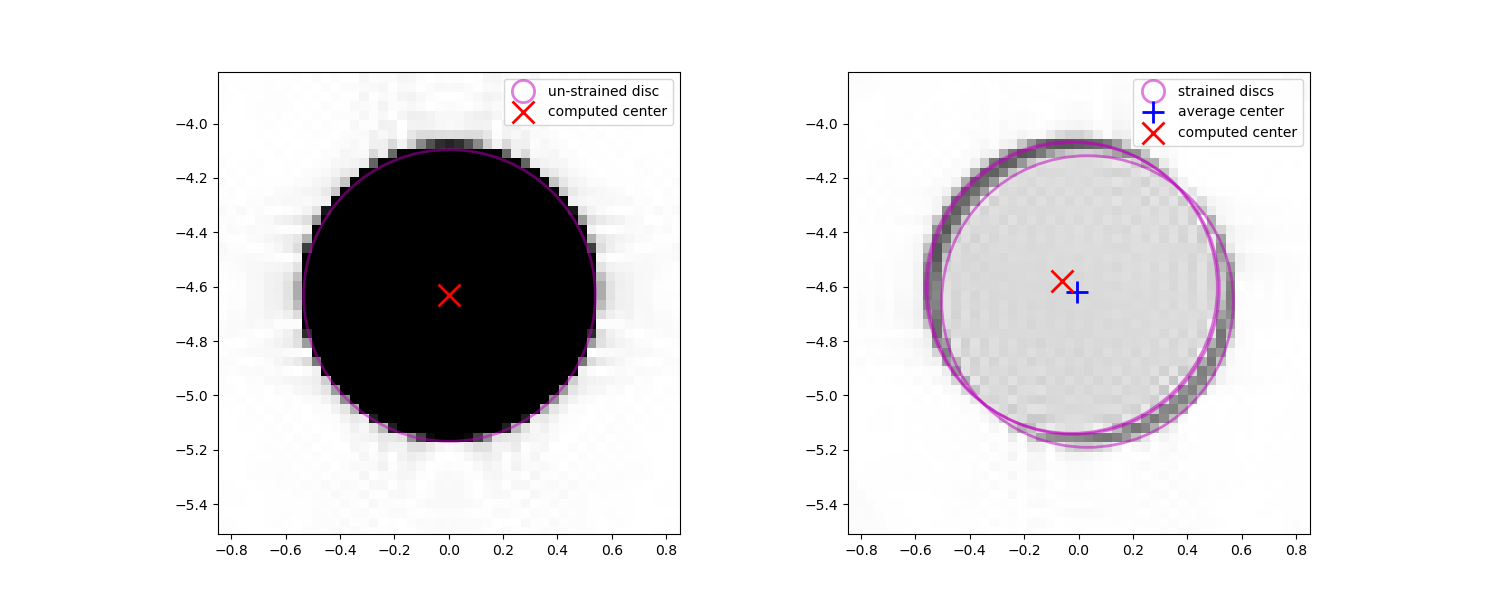

In [8]:
size = 1
key = 'com', rotate
ekey = ('exact ' + key[0], key[1])
k = errors[key][0,:,:2].argmax()
i,j,k,bad_spot = unravel_index(k,errors[key][0,:,:2].shape)
# print(repr(strain[i,j,k]))

figure('Predicted and computed spot locations')
thresh, scale = .08 if rotate else .01, lambda x: maximum(0,minimum(x,thresh)**.5)
plt.subplot(121); plot_FT(-scale(gt[(key[1],'precessed')]), cmap='gray')
if size==0: # small
    this_spot = spots[key[1]][bad_spot]
    ax = this_spot-.2*spot_rad[key[1]][1], this_spot+.2*spot_rad[key[1]][1]
    pms = {'markersize':16,'mew':2}
elif size==1: # medium
    this_spot = spots[key[1]][bad_spot]
    ax = this_spot-spot_rad[key[1]][1], this_spot+spot_rad[key[1]][1]
    pms = {'markersize':16,'mew':2}
else: # large
    ax = [(-6,-6),(6,6)]
    pms = {'markersize':8,'mew':2}
ax = ax[0][0], ax[1][0], ax[0][1], ax[1][1]
if size==1:
    plt.plot(coms[ekey][:,0], coms[ekey][:,1],'mo', label='un-strained disc', fillstyle='none', markersize=210, mew=2, alpha=.5)
plt.plot(coms[ekey][:,0], coms[ekey][:,1], 'rx', label='computed center', **pms)
plt.axis(ax); lgnd=plt.legend(); # plt.title('Unstrained sample')
lgnd.legendHandles[0]._legmarker.set_markersize(pms['markersize'])

plt.subplot(122); plot_FT(-scale(DP[(key[1],'precessed')][i,j,k]), cmap='gray')
if size==0: # small
    s = concatenate(scatter[key][i,j,k])
    this_spot = predicted[key][i,j,k,bad_spot]
    ax = this_spot-.2*spot_rad[key[1]][1], this_spot+.2*spot_rad[key[1]][1]
    f_name = '_big_zoom'
elif size==1: # medium
    s = scatter[key][i,j,k,bad_spot]
    this_spot = spots[key[1]][bad_spot]
    ax = this_spot-spot_rad[key[1]][1], this_spot+spot_rad[key[1]][1]
    f_name = '_zoom'
else: # large
    ax = [(-6,-6),(6,6)]
    f_name = ''
ax = ax[0][0], ax[1][0], ax[0][1], ax[1][1]
plt.axis(ax)
if size==0:
    plt.plot(s[:,0], s[:,1],'m*', label='strained centers', **pms)
elif size==1:
    plt.plot(s[:,0], s[:,1],'mo', label='strained discs', fillstyle='none', markersize=210, mew=2, alpha=.5)
plt.plot(predicted[key][i,j,k,:,0], predicted[key][i,j,k,:,1], 'b+', label='average center', **pms)
plt.plot(coms[key][i,j,k,:,0], coms[key][i,j,k,:,1], 'rx', label='computed center', **pms)
lgnd = plt.legend(); lgnd.legendHandles[0]._legmarker.set_markersize(pms['markersize'])
# plt.title('Worst strained sample')
if alpha==1 and rotate==False:
    print('/home/rob/Dropbox (Cambridge University)/2018_strainTomography/Publications/Theory/Images/bad_prediction' + f_name + '.png')
    plt.savefig('/home/rob/Dropbox (Cambridge University)/2018_strainTomography/Publications/Theory/Images/bad_prediction' + f_name + '.png', dpi=300)

In [9]:
# from subpixelrefinement_generator import get_simulated_disc, _conventional_xc, get_experimental_square
# from numpy import pad
# this_spot = coms['exact '+name][bad_spot]; ind = [int((this_spot[1-I]-y[I][0])/(y[I][1]-y[I][0])) for I in [0,1]]

# def vec2ind(v): return ((v - array([y[1][ind[1]-tmp.shape[1]//2], y[0][ind[0]-tmp.shape[0]//2]]))/(y[1][1]-y[1][0]))
# def ind2vec(i): return (array(i)*(y[1][1]-y[1][0]) + array([y[1][ind[1]-tmp.shape[1]//2], y[0][ind[0]-tmp.shape[0]//2]]))

# if 'rxc' in name:
#     tmp = gt[0][ind[0]-int(spot_rad[1]/(y[1][1]-y[1][0])):ind[0]+int(spot_rad[1]/(y[1][1]-y[1][0])),
#                 ind[1]-int(spot_rad[1]/(y[1][1]-y[1][0])):ind[1]+int(spot_rad[1]/(y[1][1]-y[1][0]))]
# else:
#     tmp = get_simulated_disc(2*int(spot_rad[1]/(y[1][1]-y[1][0])), int(spot_rad[0]/(y[1][1]-y[1][0])))
# img = precessed[i,j,k,ind[0]-tmp.shape[0]//2:ind[0]+tmp.shape[0]//2,ind[1]-tmp.shape[1]//2:ind[1]+tmp.shape[1]//2]
# # img = pad(img,((0,4),(0,0)), 'constant')[4:]
# reg = _conventional_xc(img, tmp, 10)


# print('difference: ', abs(coms[name][i,j,k,bad_spot]-ind2vec([tmp.shape[0]//2+reg[0],tmp.shape[1]//2+reg[1]])).max())

# figure('tmp')
# plt.subplot(121)
# plt.imshow(-tmp)
# plt.plot(tmp.shape[1]/2,tmp.shape[0]/2, 'rx', markersize=16)
# plt.title('template')

# plt.subplot(122)
# plt.imshow(-img)
# plt.plot(*vec2ind(coms[name][i,j,k,bad_spot]), 'bx', label='previous guess', markersize=16)
# plt.title('image')

# plt.plot(tmp.shape[1]//2+reg[1],tmp.shape[0]//2+reg[0], 'rx', label='current guess', markersize=16)
# plt.legend()



### Accuracy of linear strain COMs for hyperplane model (independent of $\alpha$)
| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.03% |  0.12% |  0.005% |  0.027% |  +0.016%  |   0.09%  |
|    Sqrt CoM |  0.04% |  0.07% |  0.009% |  0.019% |  +0.003%  |   0.05%  |
|    Plain XC |  0.05% |  0.07% |  0.009% |  0.018% |  -0.003%  |   0.07%  |
|     Sqrt XC |  0.04% |  0.06% |  0.005% |  0.015% |  +0.007%  |   0.05%  |
|   Plain RXC |  0.04% |  0.09% |  0.006% |  0.023% |  +0.002%  |   0.07%  |
|    Sqrt RXC |  0.03% |  0.08% |  0.006% |  0.020% |  +0.002%  |   0.06%  |

--------------------------------------------------------------------------------------
## $\alpha = 0$
| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.44% |  0.89% |  0.014% |  0.047% |  -0.043%  |   1.06%  |
|    Sqrt CoM |  0.26% |  0.46% |  0.017% |  0.027% |  -0.004%  |   0.57%  |
|    Plain XC |  0.11% |  0.17% |  0.015% |  0.035% |  +0.011%  |   0.18%  |
|     Sqrt XC |  0.09% |  0.16% |  0.011% |  0.031% |  -0.004%  |   0.16%  |
|   Plain RXC |  0.18% |  0.68% |  0.016% |  0.054% |  -0.020%  |   0.70%  |
|    Sqrt RXC |  0.11% |  0.23% |  0.013% |  0.044% |  +0.004%  |   0.23%  |

--------------------------------------------------------------------------------------
## $\alpha = 0.5$
| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.27% |  0.67% |  0.005% |  0.012% |  -0.166%  |   0.74%  |
|    Sqrt CoM |  0.17% |  0.33% |  0.008% |  0.012% |  -0.089%  |   0.38%  |
|    Plain XC |  0.06% |  0.07% |  0.008% |  0.014% |  +0.012%  |   0.08%  |
|     Sqrt XC |  0.04% |  0.06% |  0.005% |  0.011% |  -0.005%  |   0.06%  |
|   Plain RXC |  0.07% |  0.10% |  0.007% |  0.019% |  -0.003%  |   0.12%  |
|    Sqrt RXC |  0.05% |  0.08% |  0.005% |  0.014% |  -0.001%  |   0.08%  |

--------------------------------------------------------------------------------------
## $\alpha = 1$
| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.08% |  0.26% |  0.004% |  0.009% |  +0.044%  |   0.28%  |
|    Sqrt CoM |  0.07% |  0.14% |  0.008% |  0.013% |  +0.019%  |   0.16%  |
|    Plain XC |  0.05% |  0.04% |  0.007% |  0.012% |  +0.006%  |   0.05%  |
|     Sqrt XC |  0.03% |  0.04% |  0.005% |  0.009% |  +0.012%  |   0.04%  |
|   Plain RXC |  0.04% |  0.06% |  0.006% |  0.013% |  +0.007%  |   0.06%  |
|    Sqrt RXC |  0.03% |  0.05% |  0.005% |  0.010% |  +0.008%  |   0.05%  |

--------------------------------------------------------------------------------------
## $\alpha = 2$
| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.04% |  0.08% |  0.003% |  0.006% |  +0.009%  |   0.09%  |
|    Sqrt CoM |  0.05% |  0.05% |  0.009% |  0.014% |  -0.003%  |   0.05%  |
|    Plain XC |  0.04% |  0.04% |  0.006% |  0.010% |  -0.015%  |   0.04%  |
|     Sqrt XC |  0.03% |  0.03% |  0.004% |  0.006% |  -0.003%  |   0.03%  |
|   Plain RXC |  0.03% |  0.05% |  0.005% |  0.010% |  -0.003%  |   0.05%  |
|    Sqrt RXC |  0.02% |  0.03% |  0.003% |  0.007% |  -0.000%  |   0.03%  |


# General Comparison
| <pre>            </pre> | hyperplane | $\alpha = 0$ | $\alpha =.5$ | $\alpha = 1$ | $\alpha = 2$ |
|-------------------------|------------|--------------|--------------|--------------|--------------|
|  Plain Centres of Mass  |     0.03%  |     0.44%    |   0.27%&nbsp;|     0.08%    |     0.04%    |
|  Sqrt Centres of Mass   |     0.04%  |     0.26%    |   0.17%      |     0.07%    |     0.05%    |
| Plain Cross Corellation |     0.05%  |     0.11%    |   0.06%      |     0.05%    |     0.04%    |
| Sqrt Cross Corellation  |     0.04%  |     0.09%    |   0.04%      |     0.03%    |     0.03%    |
| Plain Cross Referenced  |     0.04%  |     0.18%    |   0.07%      |     0.04%    |     0.03%    |
| Sqrt Cross Referenced   |     0.03%  |     0.11%    |   0.05%      |     0.03%    |     0.02%    |


In [10]:
print('alpha = ', alpha)
for name in names:
    print(TABLE(name[0], concatenate((errors[(name[1],False)],
                                      errors[(name[1],True)]), axis=-1)))

alpha =  -1
|   Plain CoM |  0.03% |  0.12% |  0.005% |  0.027% |  +0.016%  |   0.09%  |
|    Sqrt CoM |  0.04% |  0.07% |  0.009% |  0.019% |  +0.003%  |   0.05%  |
|    Plain XC |  0.05% |  0.07% |  0.009% |  0.018% |  -0.003%  |   0.07%  |
|     Sqrt XC |  0.04% |  0.06% |  0.005% |  0.015% |  +0.007%  |   0.05%  |
|   Plain RXC |  0.04% |  0.09% |  0.006% |  0.023% |  +0.002%  |   0.07%  |
|    Sqrt RXC |  0.03% |  0.08% |  0.006% |  0.020% |  +0.002%  |   0.06%  |


In [11]:
print('alpha = ', alpha)
for name in names:
    tmp = (TABLE(name[0], errors[(name[1],False)]).split(' |',1), # rotate=False
           TABLE(name[0], errors[(name[1],True)]).split(' |',1)) # rotate=True
    print(tmp[0][0]+' |<pre> </pre>|'+tmp[0][1]+'<pre></pre>|'+tmp[1][1])


alpha =  -1
|   Plain CoM |<pre> </pre>|  0.03% |  0.13% |  0.006% |  0.034% |  +0.004%  |   0.08%  |<pre></pre>|  0.04% |  0.10% |  0.005% |  0.012% |  +0.034%  |   0.10%  |
|    Sqrt CoM |<pre> </pre>|  0.03% |  0.06% |  0.005% |  0.017% |  +0.006%  |   0.05%  |<pre></pre>|  0.07% |  0.06% |  0.019% |  0.018% |  -0.003%  |   0.05%  |
|    Plain XC |<pre> </pre>|  0.05% |  0.08% |  0.008% |  0.021% |  +0.000%  |   0.07%  |<pre></pre>|  0.05% |  0.05% |  0.009% |  0.013% |  -0.007%  |   0.05%  |
|     Sqrt XC |<pre> </pre>|  0.04% |  0.07% |  0.006% |  0.019% |  -0.005%  |   0.06%  |<pre></pre>|  0.03% |  0.03% |  0.005% |  0.008% |  +0.017%  |   0.03%  |
|   Plain RXC |<pre> </pre>|  0.04% |  0.12% |  0.008% |  0.029% |  +0.002%  |   0.09%  |<pre></pre>|  0.03% |  0.04% |  0.005% |  0.010% |  +0.002%  |   0.04%  |
|    Sqrt RXC |<pre> </pre>|  0.03% |  0.10% |  0.007% |  0.025% |  +0.002%  |   0.07%  |<pre></pre>|  0.03% |  0.04% |  0.004% |  0.009% |  +0.002%  |   0.03%  |
